In [5]:
from datetime import datetime

from pymongo import MongoClient
import pandas as pd

import constants

In [6]:
mongo = MongoClient(constants.mongo_conn_string)
mongo_lt_col = mongo[constants.mongo_db][constants.mongo_lt_annotated_col]

In [8]:
query = {"date":{"$gte": datetime(2008, 12, 9)}}

cursor = mongo_lt_col.find(query, {"_id":0, "text":0})

data = [i for i in cursor]
print(len(data))

df = pd.DataFrame(data)
print(df.shape)
df.head()

43681
(43681, 10)


,para_id,source,cabinet_ents,date,year,month,day,cabinet,cabinet_no,president
0,614bbcee4307555f8af6d887,https://www.delfi.lt/news/daily/lithuania/darb...,[Premjeras],2008-12-09 14:14:38,2008,12,9,Andrius Kubilius,15,Valdas Adamkus
1,614b57664307555f8af62dce,https://www.delfi.lt/news/daily/lithuania/kam-...,[Krašto apsaugos],2008-12-09 14:21:56,2008,12,9,Andrius Kubilius,15,Valdas Adamkus
2,614b926e4307555f8af684b3,https://www.delfi.lt/news/daily/lithuania/rusi...,[Prezidentas],2008-12-09 14:50:41,2008,12,9,Andrius Kubilius,15,Valdas Adamkus
3,614bedf54307555f8af73cd8,https://www.delfi.lt/news/daily/lithuania/seim...,"[Premjeras, Finansų, Krašto apsaugos, Susisiek...",2008-12-09 16:55:57,2008,12,9,Andrius Kubilius,15,Valdas Adamkus
4,614bd51c4307555f8af70abb,https://www.delfi.lt/news/daily/lithuania/arti...,"[Premjeras, Finansų, Krašto apsaugos, Susisiek...",2008-12-09 16:55:57,2008,12,9,Andrius Kubilius,15,Valdas Adamkus


In [9]:
#df.to_parquet("Data.parquet")

# Basic Data

<AxesSubplot:>

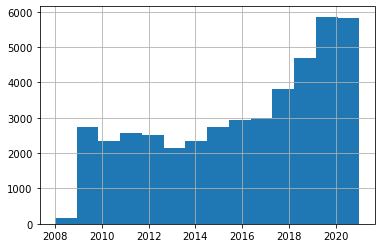

In [13]:
df.year.hist(bins=14)

In [14]:
df.cabinet.value_counts()

Saulius Skvernelis      17193
Andrius Kubilius        10186
Algirdas Butkevičius    10134
Ingrida Šimonytė         6168
Name: cabinet, dtype: int64

In [15]:
df.president.value_counts()

Dalia Grybauskaite    28184
Gitanas Nausėda       13899
Valdas Adamkus         1598
Name: president, dtype: int64

# Adding dummies for media & presidential attention for each policy sphere

In [20]:
ministries = set()
for i in list(df.cabinet_ents):
    for a in i:
        ministries.add(a)
    
for item in list(ministries):
    df[item]= df.apply(lambda x : int(item in x["cabinet_ents"]), axis = 1)


def prez_attention( list_min , minister):
    if "Prezidentas" in list_min and minister in list_min:
        return 1
    else:
        return 0
    
for item in list(ministries):
    if item != "Prezidentas":
        df["president_"+item]= df.apply(lambda x : prez_attention(x["cabinet_ents"], item), axis = 1)
    
df.head() 

,para_id,source,cabinet_ents,date,year,month,day,cabinet,cabinet_no,president,...,president_Susisiekimo,president_Švietimo ir mokslo,president_Finansų,"president_Švietimo, mokslo ir sporto",president_Kultūros,president_Energetikos,president_Aplinkos,president_Užsienio reikalų,president_Sveikatos apsaugos,president_Žemės ūkio
0,614bbcee4307555f8af6d887,https://www.delfi.lt/news/daily/lithuania/darb...,[Premjeras],2008-12-09 14:14:38,2008,12,9,Andrius Kubilius,15,Valdas Adamkus,...,0,0,0,0,0,0,0,0,0,0
1,614b57664307555f8af62dce,https://www.delfi.lt/news/daily/lithuania/kam-...,[Krašto apsaugos],2008-12-09 14:21:56,2008,12,9,Andrius Kubilius,15,Valdas Adamkus,...,0,0,0,0,0,0,0,0,0,0
2,614b926e4307555f8af684b3,https://www.delfi.lt/news/daily/lithuania/rusi...,[Prezidentas],2008-12-09 14:50:41,2008,12,9,Andrius Kubilius,15,Valdas Adamkus,...,0,0,0,0,0,0,0,0,0,0
3,614bedf54307555f8af73cd8,https://www.delfi.lt/news/daily/lithuania/seim...,"[Premjeras, Finansų, Krašto apsaugos, Susisiek...",2008-12-09 16:55:57,2008,12,9,Andrius Kubilius,15,Valdas Adamkus,...,0,0,0,0,0,0,0,0,0,0
4,614bd51c4307555f8af70abb,https://www.delfi.lt/news/daily/lithuania/arti...,"[Premjeras, Finansų, Krašto apsaugos, Susisiek...",2008-12-09 16:55:57,2008,12,9,Andrius Kubilius,15,Valdas Adamkus,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df.columns

Index(['para_id', 'source', 'cabinet_ents', 'date', 'year', 'month', 'day',
       'cabinet', 'cabinet_no', 'president', 'Krašto apsaugos', 'Premjeras',
       'Teisingumo', 'Žemės Ūkio', 'Prezidentas',
       'Socialinės apsaugos ir darbo', 'Ekonomikos ir inovacijų', 'Ūkio',
       'Vidaus reikalų', 'Susisiekimo', 'Švietimo ir mokslo', 'Finansų',
       'Švietimo, mokslo ir sporto', 'Kultūros', 'Energetikos', 'Aplinkos ',
       'Užsienio reikalų', 'Sveikatos apsaugos', 'Žemės ūkio',
       'president_Krašto apsaugos', 'president_Premjeras',
       'president_Teisingumo', 'president_Žemės Ūkio',
       'president_Socialinės apsaugos ir darbo',
       'president_Ekonomikos ir inovacijų', 'president_Ūkio',
       'president_Vidaus reikalų', 'president_Susisiekimo',
       'president_Švietimo ir mokslo', 'president_Finansų',
       'president_Švietimo, mokslo ir sporto', 'president_Kultūros',
       'president_Energetikos', 'president_Aplinkos ',
       'president_Užsienio reikalų', 'pre

In [21]:
df.to_parquet("DataEnhanced.parquet")